# Early Detection of Crop Stress From Thermal Infrared Imagery
![Hydrosat](https://uploads-ssl.webflow.com/61e4aee27ac4a95d23ab9609/61e9d6f5d6578e8c7c0cca8f_solutions-thermal-min.jpg)

In [4]:
import base64
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import os
import pystac
import requests
import xarray as xr
import rioxarray as rxr
import rasterio as rio

#from botocore.exceptions import ClientError
from datetime import date
from datetime import datetime
from matplotlib.dates import DateFormatter
from distutils.command import sdist
from matplotlib import pyplot as plt
from pyproj.crs import CRS
from pystac_client import Client
from pprint import pprint
from shapely.geometry import box, mapping, Point, Polygon
from sklearn.linear_model import LinearRegression

# Project specific packages
from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat
from herbie import FastHerbie
#import synoptic.services as ss
#from synoptic.services import stations_timeseries

os.environ['USE_PYGEOS'] = '0'


### <span style="color:green">FUNCTIONS.  No user editing is required.</span>

In [5]:
# ---------------------------------------------------------------------------------

def create_clip_polygon(geom, ds, buffer):
    """
    Create a polygon that we will use for clipping the big dataset.

    Parameters:
    ----------
    geom: dict
        Dictionary of lat and lon of center point of AOI.

    Returns:
    -------
    poly: dataframe
        Contains geometry of a square to be used for clipping.
    """
    # Using the point coords defined earlier, create a df with the point geometry.
    p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
    point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

    # Define a buffer size (for each side of the point.
    # Reproject the point df and create the new polygon.
    raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
    buffer_dist = buffer # 1km in local UTM zone

    # create a square buffer
    poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) 

    return(poly_df)

# ---------------------------------------------------------------------------------

def stac_tile_search(collection, geom, start_date, end_date):
    """
    Log into STAC and search for a specified image collection.

    Parameters:
    ----------
    collection: list
        List of tiles found in STAC.

    geom: 
        Point location to search.

    start_date, end_date: str
        Dates to search between.

    Returns:
    -------
    """
    search = catalog.search(
        collections = collection,
        intersects = geom,
        datetime = [start_date, end_date],
        max_items = 500
    )
    print ("----", search.get_all_items())
    # found_items = list(search.items()) # for pystac-client >= 0.4.0
    found_items = list(search.get_all_items()) # for pystac-client < 0.4.0

    # Filter out only the newest version of MODIS.
    if collection == 'prepped_inputs_mcd43a4':
        version_str = '061'
        new_list = [i for i in found_items if version_str in i.id]
        found_items = new_list

    found_items.reverse() # make the results ascending in time

    num_tiles = len(found_items)
    print ("Searching {} colllection .... images available: {}\n".format(collection, num_tiles))

    return (found_items, num_tiles)

# ---------------------------------------------------------------------------------

def create_aoi_image_stack(items, num_tiles, geom, asset, buffer):
    '''
    Gets images, stacks them and sorts them by date and clips them down to a smaller
    AOI size.

    Parameters:
    -----------
    itmes: list 
        List of available images.
    num_tiles: int
        Number of tiles to download (days)
    asset: str
        Name of asset to get.
    geom: x,y coords
        Coordinates around which to build a polygon
    buffer: int
        Buffer around the x,y for creating the AOI rectangele.  In meters.

    Returns:
    --------
    aoi_stack_ds: dataset as FH_StackedDataset object.
        Stack of images clipped to AOI.

    '''
    images = FH_Hydrosat(items[:num_tiles], asset=asset)

    # Stacks all the files into a dataset and then return a FH_StackedDataset object.
    stacked_images = images.stack()
    # Sort the dataset by time.
    ds = stacked_images.ds.sortby('time')

    # Create polygon Area of Interest (AOI for which to sample.).
    clip_poly_df = create_clip_polygon(geom, ds, buffer=buffer)
    # Use AOI polygon to clip the dataset dwon to size and make it into a FH_StackedDataset object.
    clipped = FH_StackedDataset(ds.rio.clip(clip_poly_df.geometry))
    aoi_stack_ds = clipped.ds

    return (aoi_stack_ds, clip_poly_df)

 # ---------------------------------------------------------------------------------   
def extract_time_series(items, bbox, tol, var_name, asset, band):
    '''
    Uses FH_Hydrosat class method point_time_series_from_items()
    to extract only a time-series.

    Parameters:
    -----------
    items: list
        Image items returned from STAC search.
    bbox: 
        Bounding box of coordinates for seacrh site.
    tol: int
        A search parameter in meters for finding point data.
    var_name: str
        Dataframe column name for data extracted.
    asset: str
        Search parameter for type of asset to be searched.
    
    Returns:
    -------
    lst_df: dataframe
        Dataframe containing date time series.
    '''
    # Sample the LST items.
    lst_res = FH_Hydrosat(items, asset=asset)

    # Set the point for time-series extraction.
    point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)
    print ("----", point_wgs84)
    
    # Extract time-series data using function.
    band = int(band) # band needs to be an int because it comes in as a string.
    lst_k  = lst_res.point_time_series_from_items(point_wgs84, tol=tol, nproc=6, pad=0, band=band) 

    # Create a datetime dataframe
    lst_dt = lst_res.datetime
    lst_df = pd.DataFrame({var_name: lst_k,
                       'datetime': pd.to_datetime(lst_dt)}).sort_values(by='datetime')
    
    # Get the date in the correct/consistent format.
    lst_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in lst_df['datetime']]
    lst_df['date'] = pd.to_datetime(lst_df['date'])
    lst_df.drop(columns='datetime', inplace=True)
    lst_df.set_index('date', drop=True, inplace=True)
    
    return (lst_df)

# ---------------------------------------------------------------------------------

def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/
    ${HOME}/.config/herbie/config.toml

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
    start_hr_time = "{} 17:30".format(start)
    # Create a range of dates
    DATES = pd.date_range(
        start=start_hr_time,
        periods=days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)

    FH.download("TMP:2 m")
    t_ds = FH.xarray("TMP:2 m", remove_grib=False)

    FH.download("DPT:2 m")
    td_ds = FH.xarray("DPT:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    t_ds_point = t_ds.herbie.nearest_points(points=(lon, lat))
    td_ds_point = td_ds.herbie.nearest_points(points=(lon, lat))
   
    return (t_ds_point, td_ds_point)

# ---------------------------------------------------------------------------------
def get_synoptic_obs(station):
    # ---------------------------------------------------------------------
    # Request a single station by listing the station id.  
    # ---------------------------------------------------------------------
    params = dict(
        stid=station,
        vars=['air_temp', 'dew_point_temperature'],
        start=datetime(2020, 4, 1),
        end=datetime(2020, 10, 30)
    )
    data = stations_timeseries(verbose='HIDE', **params)

    # Filter data to get only 00z obs.
    sfc_obs = data.loc[(data.index.hour == 17) & (data.index.minute == 30)]
    sfc_obs.drop(columns='dew_point_temperature_set_1', inplace=True)
    # convert datetime column to just date
    sfc_obs['time'] = sfc_obs.index.date
    sfc_obs.reset_index(inplace=True)
    sfc_obs.set_index('time', inplace=True)

    # Change date format to be consistent.
    sfc_obs.index = pd.to_datetime(sfc_obs.index)
    sfc_obs.index = sfc_obs.index.strftime('%Y-%m-%d')

    return (sfc_obs)

# ---------------------------------------------------------------------------------

def read_ameriflux(data_path):

    print ('Reading file {}'.format(data_path))
    
    df = pd.read_csv(data_path, header=2, na_values=[-9999])

    # Save value column names
    value_cols = df.columns[2:]

    # Convert timestamp objects
    df['start'] = df['TIMESTAMP_START'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )
    df['end'] = df['TIMESTAMP_END'].apply(
        lambda x: datetime.strptime(str(x), "%Y%m%d%H%M")
        )

    # Convert obs to UTC time.txt.
    # # UTC_OFFSET is a global var.
    df['start'] = df['start'] - timedelta(hours=UTC_OFFSET)
    df['end'] = df['end'] - timedelta(hours=UTC_OFFSET)
    df['start'] = df['start'].dt.tz_localize('UTC')
    df['end'] = df['end'].dt.tz_localize('UTC')

    # Drop NA
    df = df.dropna(subset=value_cols, how='all')

    df = df.set_index('start')
    col_order = (['end', 'TIMESTAMP_START', 'TIMESTAMP_END'] 
                 + value_cols.to_list())
    df = df[col_order]

    return df

### <span style="color:green">Login to STAC.</span>

In [6]:
# Open credentials file.
with open('../secrets/creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

### <span style="color:green">Set up analysis.  User edits required in cell below.</span>

In [8]:
# ---------------------------------------------------------------------------
# USER EDITS REQUIRED -------------------------------------------------------
# ---------------------------------------------------------------------------

analysis = 'Corn'

# Want met obs in UTC time to match satellites.
UTC_OFFSET = 7

# Insitu point locations
insitu_met_points = {
    'Rice': [38.1235, -121.5490],
    'Corn': [38.1091, -121.5351],
    'Alfalfa': [38.0992, -121.4993]
}

# Center point of crop fields.
crop_center_points = {
    'Rice': [-121.550, 38.123],
    'Corn': [-121.536, 38.109],
    'Alfalfa': [-121.501, 38.099],
    'Ames': [-93.701, 42.000],
}

bbox = [-121.52, 38.11, -121.54, 38.09]

# Define size of AOI.
#    Length    x    Width 
# (buffer * 2) x (buffer * 2)
buffer = 250

# Specify dates & hour for LST analysis.
# start_date = "2016-08-13T00:00:00Z"
# end_date = "2022-05-26T00:00:00Z"
start = "2016-01-01"  
end = "2022-12-30"  
hr_s = "00:00:00"  
hr_e = '23:59:59'

# ---------------------------------------------------------------------------
# ---------------------------------------------------------------------------

# Define paths to data
data_path = os.path.join('../data', 'Ameriflux')

if analysis == 'Alfalfa':
    met_path = os.path.join(data_path, 
                                'AMF_US-Bi1_BASE-BADM_8-5',
                                'AMF_US-Bi1_BASE_HH_8-5.csv')
elif analysis == 'Corn':
    met_path = os.path.join(data_path,
                                'AMF_US-Bi2_BASE-BADM_13-5',
                                'AMF_US-Bi2_BASE_HH_13-5.csv')
elif analysis == 'Rice':
    met_path = os.path.join(data_path,
                                'AMF_US-DS3_BASE-BADM_1-5',
                                'AMF_US-DS3_BASE_HH_1-5.csv')

# Create dict of coords.  Will be used to create a polygon for our AOI.
geom = {'type': 'Point', 'coordinates': crop_center_points[analysis]} 

# We need the total num of days for the analysis to get hrrr data.
f = start.split("-")
l = end.split("-")

# Creating dates from split arrays above.
f_dt = date(int(f[0]), int(f[1]), int(f[2]))  
l_dt = date(int(l[0]), int(l[1]), int(l[2]))  
num_days = (l_dt - f_dt)
num_days = num_days.days

# Need to do some formating for various requirements.
hr_s_form = "T{}Z".format(hr_s)
hr_e_form = "T{}Z".format(hr_e)
start_date = start + hr_s_form
end_date = end + hr_e_form

### <span style="color:green">Get dates with available data. </span>

In [13]:
# Collection to search for.
# collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
# collections = ["pydms_sharpened_landsat"]
collections = ["pydms_sharpened_landsat"]
asset = 'lst'

# Search STAC for available images.
(found_items, num_tiles) = stac_tile_search(collections, geom, start_date, end_date)

print (f"First date: {found_items[0]}")
print (f"Last date: {found_items[-1]}")

---- <pystac.item_collection.ItemCollection object at 0x170a78e10>
Searching ['pydms_sharpened_landsat'] colllection .... images available: 135

First date: <Item id=sharpened_10SFH_hires_lst_mosaic_screened_LC08_20210109_with_S2_10SFH_median_composite_20210109_screened>
Last date: <Item id=sharpened_10SFH_hires_lst_mosaic_screened_LC08_20221230_with_S2_10SFH_median_composite_20221230_screened>


### <span style="color:green">Get NDVI data into dataframe. </span>

In [ ]:
# Check if crop rotation.

# Extract red
asset = 'surface_reflectance_red'
tolerance = 40
(red_time_series_df) = (extract_time_series(found_items, bbox, tolerance, 'red_sr', asset, band=0 ))
        
# Extract nir
asset = 'surface_reflectance_nir'
(nir_time_series_df) = (extract_time_series(found_items, bbox, tolerance, 'nir_sr', asset, band=0 ))
        
# Copute NDVI
ndvi_df = pd.DataFrame()
ndvi = ((nir_time_series_df['nir_sr'] - red_time_series_df['red_sr']) / (nir_time_series_df['nir_sr'] + red_time_series_df['red_sr']))
        
# Give the ndvi data column an appropriate name.
var_name = "ndvi_starfm_band"
ndvi_df[var_name] = ndvi

### <span style="color:green">Set dates for LST analysis based on NDVI range. </span>

In [ ]:
# Set dates code

### <span style="color:green">Get LST data for selected dates. </span>

In [ ]:
# Extract data from AOI. 
# (aoi_lst_da, aoi_df) = create_aoi_image_stack(found_items, num_tiles, geom, asset, buffer)

# Extract data from point.
# (lst_time_series_df) = (extract_time_series(found_items, bbox, int(40), 'fused_lst', asset, int(0)))

### <span style="color:green">Now get mean LST data for selected dates. </span>

In [ ]:
# Get mean of all pixels for each time-step.
aoi_mean_lst_da = aoi_lst_da.isel(band=0).mean(dim=["x", "y"])

# Convert to dataframe.
aoi_mean_lst_df = aoi_mean_lst_da.to_dataframe(name='starfm_lst')
# Change date format to be consistent.
aoi_mean_lst_df.index = pd.to_datetime(aoi_mean_lst_df.index)
aoi_mean_lst_df.index = aoi_mean_lst_df.index.strftime('%Y-%m-%d')

# Create df with a complete list of dates.
days = pd.date_range(start, end)
dates_df = pd.DataFrame({'time': days})
dates_df['time'] = pd.to_datetime(dates_df.time)
dates_df.set_index('time', inplace=True)
# Change date format to be consistent.
dates_df.index = dates_df.index.strftime('%Y-%m-%d')

# Merge each df into master dataframe.
# Merge on index (date) and keep all rows from both dfs (inner join).
lst_df = pd.merge(
    dates_df, aoi_mean_lst_df, 
    left_index=True, right_index=True, how = 'outer')  

# Interpolate missing values.
interpd_aoi_lst_df = lst_df.interpolate(method='linear', inplace=False)
# Drop uneeded columns.
interpd_aoi_lst_df.drop(columns=['band', 'spatial_ref'], inplace=True)

# Plot up a time series of of the daily AOI mean LST.
fig, ax = plt.subplots(figsize=(12, 6))

ax = plt.plot(interpd_aoi_lst_df.starfm_lst, marker='o', markersize=4, c='blue')

plt.title('AOI Mean of Fused LST Time Series')
plt.grid(True)
plt.ylabel('Fused LST [K] (20 m)')
plt.xticks(rotation=45)
plt.show()


### Now, we'll calculate CATD using the LST and 2-m Temperature.

In [ ]:
# CATD will be calculated as:
# (CATD = LST - 2 m Temperature)

# Calculate CATD.
catd_df = pd.DataFrame()
catd_df['catd'] = interpd_aoi_lst_df['starfm_lst'].sub(hrrr_df['t2m'])

# Plot up a time series of of the daily AOI mean LST.
fig, ax = plt.subplots(figsize=(12, 6))

ax = plt.plot(catd_df, marker='s', markersize=8, c='green')

plt.title('CATD Time Series for All Pixels')
plt.grid(True)
plt.ylabel('CATD (20 m)')
plt.xticks(rotation=45)
plt.show()


### Calculate NDVI

In [ ]:
# Surface reflectance is extracted for and NDVI is calculated.
    
# Search STAC for available images from collection..
collection = "starfm_predictions_modis_s2"
(found_items, num_tiles) = stac_tile_search(collection, geom, start_date, end_date)

# Extract red band data from aoi.. 
asset='surface_reflectance_red'
(aoi_red_da) = create_aoi_image_stack(found_items, num_tiles, geom, asset, buffer)

# Extract nir band data from aoi. 
asset='surface_reflectance_nir'
(aoi_nir_da) = create_aoi_image_stack(found_items, num_tiles, geom, asset, buffer)

# Get mean of all pixels for each time-step.
aoi_mean_red_da = aoi_red_da.isel(band=0).mean(dim=["x", "y"])
aoi_mean_nir_da = aoi_nir_da.isel(band=0).mean(dim=["x", "y"])

# Calculate ndvi.
ndvi_da = (aoi_mean_nir_da - aoi_mean_red_da)  / (aoi_mean_nir_da + aoi_mean_red_da)

# Create our own dataframe instead of using to_dataframe which takes
# forever dealing with the dask graphs.
# ndvi_vals = ndvi_da.values()
# ndvi_dates = ndvi_da.time().values
# ndvi_df = pd.DataFrame({"time": ndvi_dates, "ndvi": ndvi_vals})


# Convert to dataaframe
ndvi_df = ndvi_da.to_dataframe(name='ndvi')

# Change date format to be consistent.
# Set the index to date just like the other dataframes.

# Change date format to be consistent.
ndvi_df.index = ndvi_df.index.strftime('%Y-%m-%d')


### Plot Mean CATD and Mean NDVI

In [ ]:
# Plot up a time series of of the daily AOI mean LST.
fig, ax1 = plt.subplots(figsize=(12, 6))
# Plot on 2 y-axes.
ax2 = ax1.twinx()  

ax1.plot(catd_df.index, catd_df.catd, marker='s', markersize=8, c='green', label='CATD')
ax2.plot(ndvi_df.index, ndvi_df.ndvi, marker='s', markersize=8, c='blue', label='NDVI')

#ax1.set_ylabel("Fused CATD", color='green', fontsize=14)
#ax2.set_ylabel(label=label, color='blue', fontsize=14)
ax1.set(ylim=(-25, 25), ylabel="CATD")
ax2.set( ylabel="NDVI")

ax1.grid(True) 

plt.title('AOI Mean CATD & Mean NDVI')
plt.xticks(rotation=45)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)

ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

### Calculate VPD and plot CATD vs. VPD.

In [ ]:
# Calculate Vapor Pressure Deficit (VPD).
# e = vapor pressure
# es = saturated vapor pressure.
e = 6.11 * 10 ** ((7.5 * (met_obs_df['dew_point_temperature'])) / (237.3 + (met_obs_df['dew_point_temperature'])))
es = 6.11 * 10 ** ((7.5 * (met_obs_df['air_temp'])) / (237.3 + (met_obs_df['air_temp'])))
vpd = es - e

# Convert LST from K to C.
c_lst_df = lst_df['starfm_lst'] - 273.15

# Calculate CATD this time in celcius.
catd_obs_df = c_lst_df.sub(met_obs_df['air_temp'])

# Plot CATD vs. VPD
plt.scatter(vpd['2020-07-01':'2020-08-30'], catd_obs_df['2020-07-01':'2020-08-30'], c='blue', alpha=0.5)
plt.xlabel('Vaopr Pressure Deficit (VPD)')
plt.ylabel('CATD')
plt.title('AMES - CATD (Mean of 500 sqm AOI) vs. Observed VPD')
plt.show()


## <span style="color:green">Get Temp and Vapor Pressure from insitsu site.</span>
### I want to take the single temp value for each time step and broadcast it across
### a 25 x 25 array to match the LST dataarray.  Then, once the two dataarrays are of
### the same size and shape, I can subract the two to get a catd for each grid cell for each time step.

In [382]:
# Get observed insitsu 'TA' and 'VPD_PI' from local csv files.

# AMF_US-Bi1_BASE_HH_8-5.csv
bi1_df = read_ameriflux(met_path)
# AMF_US-Bi2_BASE_HH_13-5
# bi2_df = read_ameriflux(bi2_data_path)
# AMF_US-DS3_BASE-BADM_1-5
# bi3_df = read_ameriflux(ds3_data_path)

#bi1_df.index = pd.to_datetime(bi1_df.index)
#utc_april_fools = bi1_df.index.astimezone(datetime.timezone.utc)
#print (bi1_df.index, utc_april_fools )

#bi1_df.TA
#bi1_df.VPD_PI

temp_list = []
vpd_list = []
da_temp_list = []
da_vpd_list = []

# Loop through each time step of the LST da.
for i in (aoi_lst_da.time):

    # Convert date to proper format
    dt = pd.to_datetime(i.item())

    # Get temp and VPD from the csv.
    ta = bi1_df.TA.iloc[bi1_df.index.get_loc(dt, method='nearest')]
    # Convert vpd from hpa to kpa.
    vpd = bi1_df.VPD_PI.iloc[bi1_df.index.get_loc(dt, method='nearest')] / 10
        
    # Save each temp in an array for later on.
    temp_list.append(ta)
    # Convert vpd from hpa to kpa.
    vpd_list.append(vpd)

    # Build dataarray of temp and vpd. --------------------------------

    # Create one datarray per time step.
    time = pd.date_range(dt, periods=1)

    # Use coords from LST da.
    temp_da = (xr.DataArray(
        data=ta,
        coords={'time': time, 'y': aoi_lst_da.y, 'x': aoi_lst_da.x, 'band':1},
        dims=['time', 'y', 'x'],
        name='TA',
        ))
  
    # Use coords from LST da.
    vpd_da = (xr.DataArray(
        data=vpd,
        coords={'time': time, 'y': aoi_lst_da.y, 'x': aoi_lst_da.x, 'band':1},
        dims=['time', 'y', 'x'],
        name='VPD',
        ))
            
    # Stick each da into a list.
    da_temp_list.append(temp_da)
    da_vpd_list.append(vpd_da)

# Concat the lists of das along time.
ta_stack = xr.concat(da_temp_list, dim="time")
vpd_stack = xr.concat(da_vpd_list, dim="time")

Reading file ../data/Ameriflux/AMF_US-Bi2_BASE-BADM_13-5/AMF_US-Bi2_BASE_HH_13-5.csv


/var/folders/zs/pstrmbpn6t75t6hdl9_v8_8w0000gn/T/ipykernel_1235/939926379.py:29: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  ta = bi1_df.TA.iloc[bi1_df.index.get_loc(dt, method='nearest')]
/var/folders/zs/pstrmbpn6t75t6hdl9_v8_8w0000gn/T/ipykernel_1235/939926379.py:29: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ta = bi1_df.TA.iloc[bi1_df.index.get_loc(dt, method='nearest')]
/var/folders/zs/pstrmbpn6t75t6hdl9_v8_8w0000gn/T/ipykernel_1235/939926379.py:31: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  vpd = bi1_df.VPD_PI.iloc[bi1_df.index.get_loc(dt, method='nearest')] / 10
/var/folders/zs/pstrmbpn6t75t

## <span style="color:green">Get DT formats consistent. </span>

In [383]:
## DT Format to match is strftime("%Y-%m-%dT%H:%M:%S.%f") ##
lst_time_vals = [datetime.strftime(t, format="%Y-%m-%dT%H:%M:%S.%f") for t in aoi_lst_da.time.values]
lst2_da = aoi_lst_da.assign_coords({"time": lst_time_vals})

# the ta_stack time variables need to be converted to datetime first (they are np.datetime64)
ta_time_vals = [datetime.strftime(pd.Timestamp(t), format="%Y-%m-%dT%H:%M:%S.%f") for t in ta_stack.time.values]
ta_stack2 = ta_stack.assign_coords({"time": ta_time_vals})

vpd_time_vals = [datetime.strftime(pd.Timestamp(t), format="%Y-%m-%dT%H:%M:%S.%f") for t in vpd_stack.time.values]
vpd_stack2 = vpd_stack.assign_coords({"time": vpd_time_vals})

# Check if they are the same.
# for i,j in zip(ta_stack2.time.values, lst2_da.time.values):
#     print(f"{i} == {j}, {i==j}")

## Calculate and Plot CATD

In [384]:
# Subtract the dataarrays to compute CATD.
# Convert from K to celcius first to match the insitsu obs.
#lst2_b0_da = (lst2_da.sel(band=1)) - 273.15
lst2_b0_da = (lst2_da) - 273.15

# Calculate CATD
catd_da = lst2_b0_da - ta_stack2

# centroid = aoi_df.geometry[0].centroid
# set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

# ax = catd_da.plot(x='x', y='y', col='time', col_wrap=5, vmin=-25, vmax=25)
# ax.set_xlabels('Easting [m]')
# ax.set_ylabels('Northing [m]')
# ax.map(lambda: plt.plot(set_x, set_y, markersize=20, marker=".", color="m"))

# plt.show()
centroid = aoi_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

#print(lst2_b0_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20).values, )
#print(ta_stack2.sel(x=set_x, y=set_y, method='nearest', tolerance=20).values.reshape(1,-1), )
#print(catd_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20).values)

### Plot CATD values for all x and y against VPD 

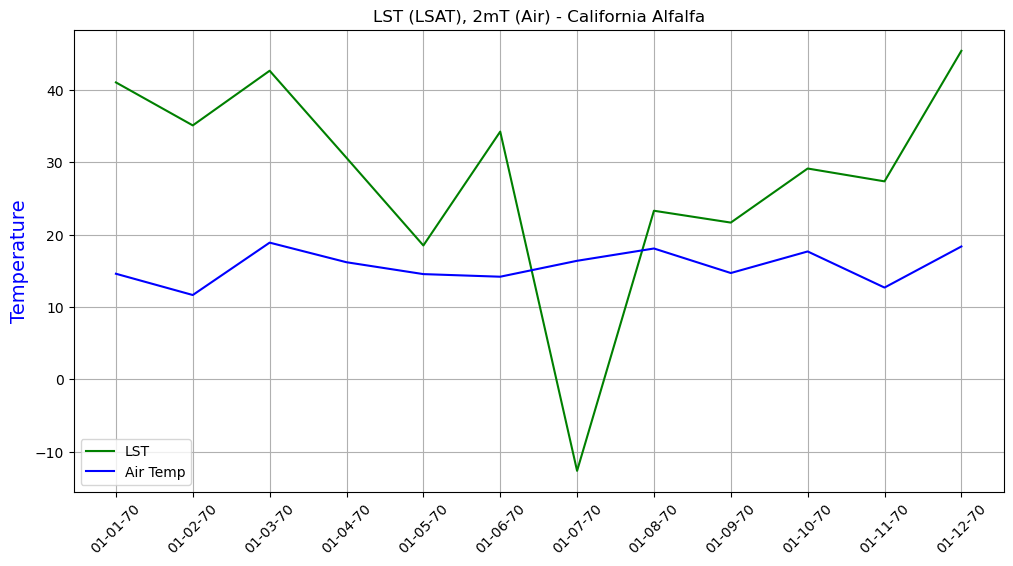

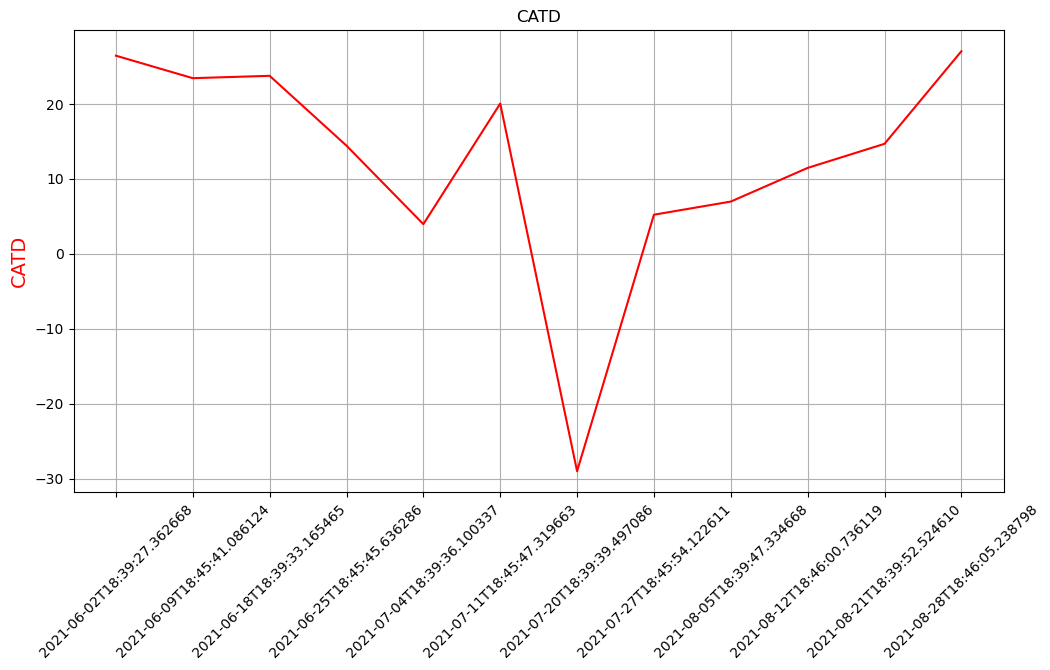

In [375]:
from matplotlib.dates import DateFormatter

centroid = aoi_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

fig, ax1 = plt.subplots(figsize=(12, 6))
fig, ax2 = plt.subplots(figsize=(12, 6))

ax1.plot(lst2_b0_da.time, lst2_b0_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='green', label='LST')
ax1.plot(ta_stack2.time, ta_stack2.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='blue', label='Air Temp')

ax2.plot(catd_da.time, catd_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='red')

ax1.set_ylabel("Temperature", color='blue', fontsize=14)
ax2.set_ylabel("CATD", color='red', fontsize=14)

ax1.set_title(f"LST (LSAT), 2mT (Air) - California {analysis}")
ax2.set_title('CATD')

ax1.grid(True)
ax2.grid(True)

ax1.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)

ax1.legend()

# Define the date format
date_form = DateFormatter("%m-%d-%y")
ax1.xaxis.set_major_formatter(date_form)

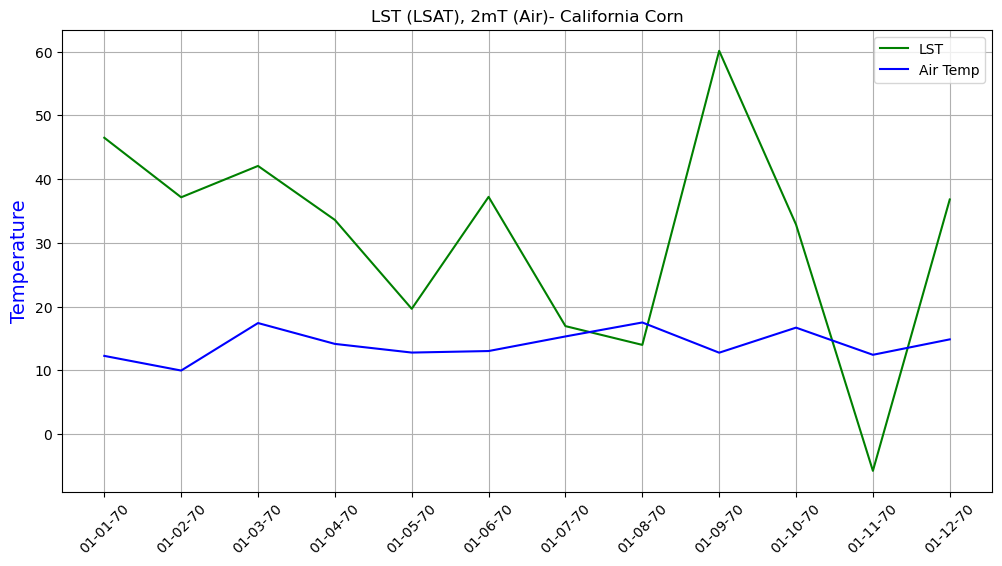

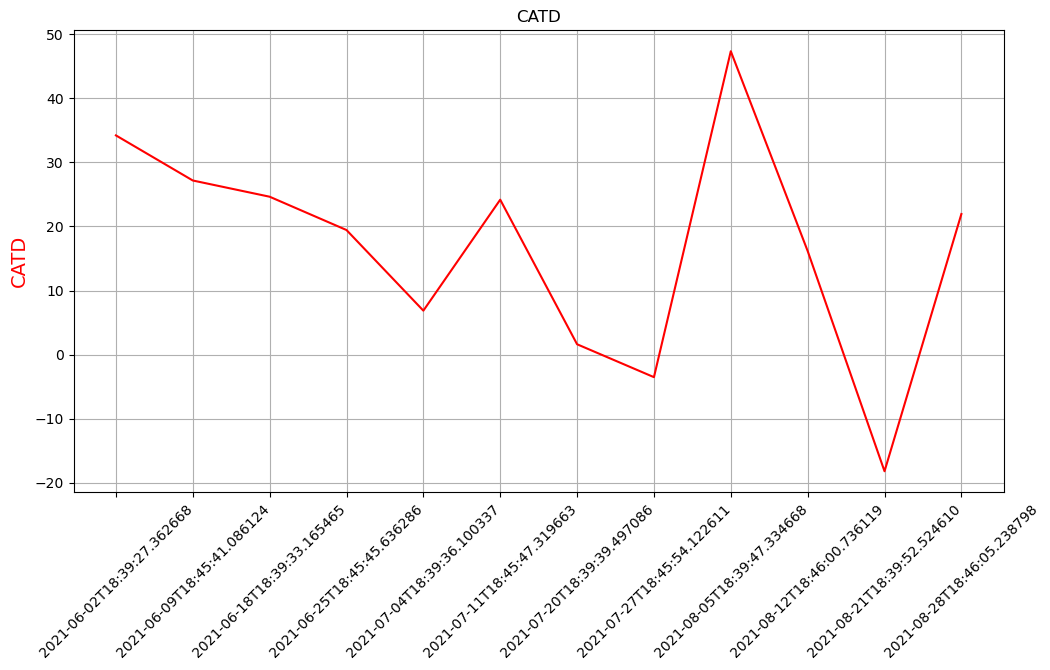

In [385]:

centroid = aoi_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

fig, ax1 = plt.subplots(figsize=(12, 6))
fig, ax2 = plt.subplots(figsize=(12, 6))

ax1.plot(lst2_b0_da.time, lst2_b0_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='green', label='LST')
ax1.plot(ta_stack2.time, ta_stack2.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='blue', label='Air Temp')

ax2.plot(catd_da.time, catd_da.sel(x=set_x, y=set_y, method='nearest', tolerance=20), c='red')

ax1.set_ylabel("Temperature", color='blue', fontsize=14)
ax2.set_ylabel("CATD", color='red', fontsize=14)

ax1.set_title(f"LST (LSAT), 2mT (Air)- California {analysis}")
ax2.set_title('CATD')

ax1.grid(True)
ax2.grid(True)

ax1.tick_params(axis='x', labelrotation = 45)
ax2.tick_params(axis='x', labelrotation = 45)

ax1.legend()

# Define the date format
date_form = DateFormatter("%m-%d-%y")
ax1.xaxis.set_major_formatter(date_form)

## Compute quantiles to get upper & lower bounds of CATD vs VPD.

In [386]:

upper_list = []
lower_list = []
up_lo_list = []
time_list = []

for i, t in enumerate(catd_da):
    upper_list.append(np.percentile(t.values, 90))
    lower_list.append(np.percentile(t.values, 10))
    time_list.append(t.time.item())

catd_percentiles_df = pd.DataFrame(list(zip(time_list, upper_list, lower_list)),
               columns =['time', '90th', '10th'])

vpd_df = pd.DataFrame(list(zip(time_list, vpd_list)),
               columns =['time', 'vpd'])


## Linear Regression of CATD vs VPD

Slope: [[-0.00443707]] This will be the B in our equation.
Intercept: [0.50318675] This will be the A in our equation.


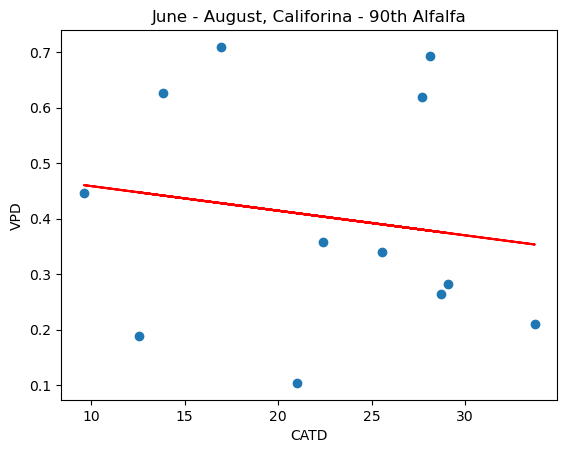

In [377]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['90th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('CATD')
plt.title('June - August, Califorina - 90th {}'.format(analysis))
plt.show()

Slope: [[0.00238027]] This will be the B in our equation.
Intercept: [0.387292] This will be the A in our equation.


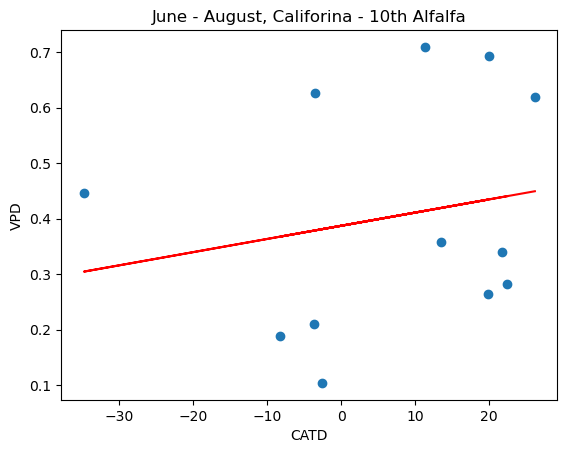

In [378]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['10th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('CATD')
plt.title('June - August, Califorina - 10th {}'.format(analysis))
plt.show()

Slope: [[-0.00400019]] This will be the B in our equation.
Intercept: [0.53934472] This will be the A in our equation.


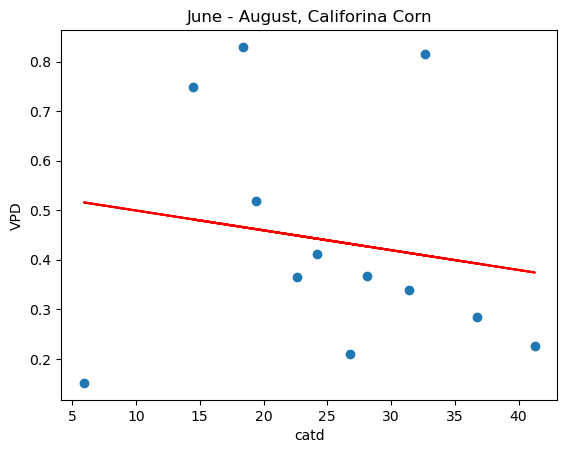

In [389]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['90th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('catd')
plt.title('June - August, Califorina {}'.format(analysis))
plt.show()

Slope: [[0.00010137]] This will be the B in our equation.
Intercept: [0.43776838] This will be the A in our equation.


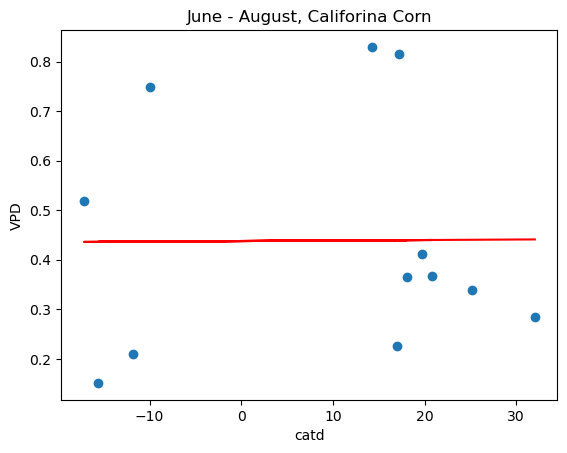

In [390]:
# Need numpy for the linear regression.
# We'll convert both of our dfs to nump and add them together.
# We'll do the same for time but oduble it up so we have arrays
# of the same lebgth.
#d = up_df['70th'].to_numpy() #+  
#v = vpd_df['vpd'].to_numpy() #+ 
d = catd_percentiles_df['10th'].to_numpy()
v = vpd_df['vpd'].to_numpy()

# Arrays need to be reshaped for some reason.
dd = d.reshape(-1,1)
vv = v.reshape(-1,1)

linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(dd,vv)  # perform linear regression
Y_pred = linear_regressor.predict(dd)  # make predictions

print('Slope:' ,linear_regressor.coef_, "This will be the B in our equation.")
print('Intercept:', linear_regressor.intercept_, 'This will be the A in our equation.')

plt.scatter(dd, vv)
plt.plot(dd, Y_pred, color='red')
plt.ylabel('VPD')
plt.xlabel('catd')
plt.title('June - August, Califorina {}'.format(analysis))
plt.show()

### CWSI-EB (Crop Water Stress Index) - Katimbo et al (2022) in Agricultural Water Management.

CWSI = ((Tc - Ta)a - (Tcl - Ta)U) / ((Tcu - Ta)L - (Tcl - Ta)L)

    Tc = canopy Temp (fused LST)
    Ta = ambient air temp (HRRR 2mT)
    Tcl = Tc of well transpiring veg (from aoi.max)
    Tcu = Tc of non-transpiring veg (from aoi.min)
    
    (Tcl - Ta)L = A + B * VPD

        VPD = e - es
        e = 6.11 × 10 exp(7.5 × Td / 237.3 + Td )
        es = 6.11 × 10 exp(7.5 × T / 237.3 + T )
        A = intercept of a regression of (Tc - Ta) and VPD
        B = slope of a regression of (Tc - Ta) and VPD

    (Tc - Ta)a = A + B * VPG
    
        VPG = Ta - (Ta + A)
        A = intercept of a regression of (Tc - Ta) and VPD
        B = slope of a regression of (Tc - Ta) and VPD